In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import sympy as sym
import warnings

from IPython.display import display, Math, clear_output
from numpy.lib.scimath import sqrt as csqrt
from scipy import constants
from scipy.constants import c
from scipy.constants import value
from scipy.signal import correlate, lfilter
from numpy.random import normal
import os

from optic.core import parameters
from optic.dsp import firFilter, pulseShape,  lowPassFIR,  pnorm
from optic.models import mzm, photodiode
from optic.plot import eyediagram
from commpy.utilities  import signal_power, upsample

In [3]:
def fwhm(band, func, dB):
    from scipy.signal import find_peaks
    peak, pd = find_peaks(func)
    rmax = func[peak[np.argmax(func[peak])]]

    min = 0
    max = 0

    if dB == True: 
        dB = 3
        rmax = rmax-dB
    else: 
        dB = 0 
        rmax = rmax/2

    for i in range(peak[np.argmax(func[peak])], 0, -1):
        if (func[i] <(rmax) and func[i+1] < (rmax)):
            min = i
            break

    for i in range(peak[np.argmax(func[peak])], len(band) - 1):
        if (func[i-1] > (rmax) and func[i] < (rmax)):
            max = i
            break

    r = (func[min] +func[max])/2
    fwhm = np.round((abs(band[max]-band[min])))

    return fwhm,r,min,max

# Base Analysis

### Mapping and Upsample

Modulation signals: [-1  1]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

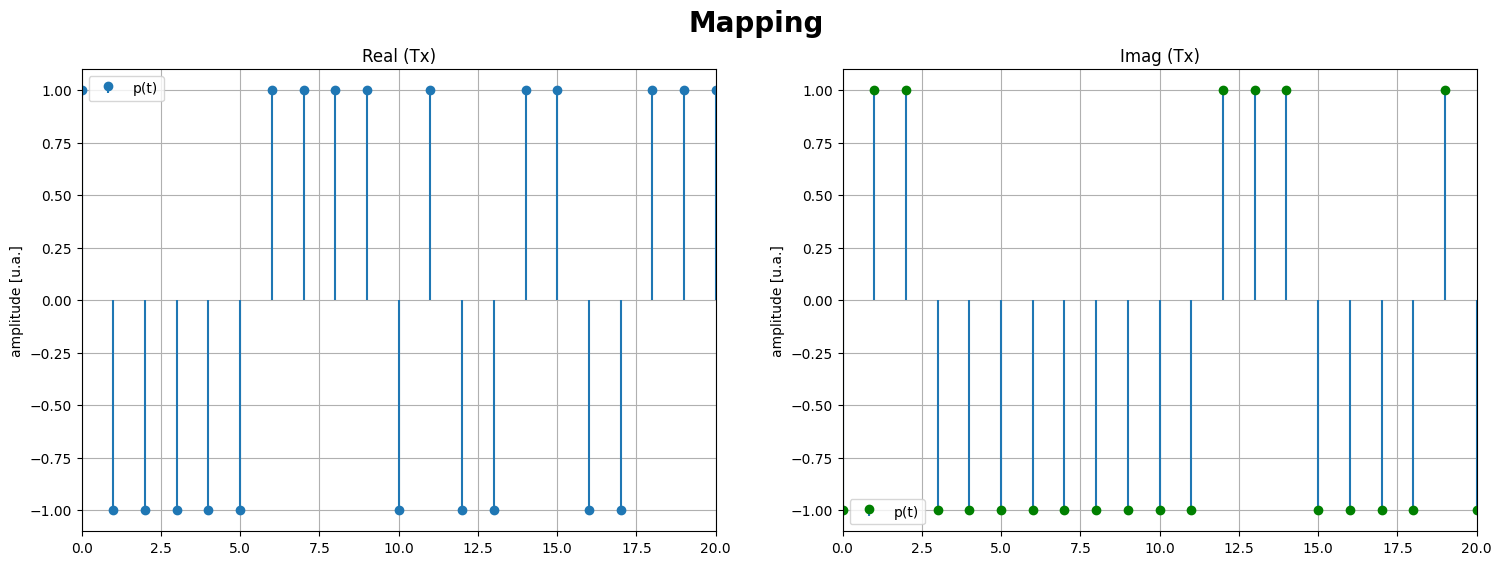

In [49]:
N = 2 # N-PAM
NumAm = 10000 # Número de amostras
choiceArray = np.arange(-N+1,N,2)

Rs  = 100e9/np.log2(N) # Taxa de símbolos (para o caso do OOK Rs = Rb)
SpS = 16 # Samples per symbol

Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

sTx1 = np.random.choice(choiceArray, NumAm) # Subchannel 1
sTx2 = np.random.choice(choiceArray, NumAm) # Subchannel 2
sTx = sTx1 + 1j*sTx2 # Complex representation of subchannels

# upsampling
symbolsUp = upsample(sTx, SpS)

fig, ax= plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f'Mapping', fontsize=20, fontweight='bold')
ax[0].stem(np.arange(0,len(sTx.real)), sTx.real,'-', label = 'p(t)', basefmt=" ")
ax[0].set_ylabel('amplitude [u.a.]')
ax[0].set_xlim(0,20)
ax[0].set_title('Real (Tx)')
ax[0].grid()
ax[0].legend()

ax[1].stem(np.arange(0,len(sTx.imag)), sTx.imag,'-', label = 'p(t)', basefmt=" ", markerfmt='g')
ax[1].set_ylabel('amplitude [u.a.]')
ax[1].set_xlim(0,20)
ax[1].set_title('Imag (Tx)')
ax[1].grid()
ax[1].legend()

print(f'Modulation signals: {choiceArray}')
display(Math('N = %5.0f ~~~~~~~~ R_{symbol} = %5.2f~GBd/s ~~~~~~~~ R_{bit} = %5.2f~Gb/s ~~~~~~~~ SpS = %5.0f'  %(N, Rs*1e-9, Rs*np.log2(N)*1e-9 , SpS)))
display(Math('T_{symbol} = %5.2f ns ~~~~~~~~ F_{sample} = %5.2f~GHz ~~~~~~~~ T_{sample} = %5.2f~ps'  %(Ts*1e9, Fa*1e-9, Ta*1e12)))

### Pulse and Shaping

In [5]:
def cos(x, f, theta):
    return np.cos(2*np.pi*f*x + theta*np.pi/180)

C:\Users\lucas\AppData\Local\Temp\ipykernel_20400\2088421701.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(np.arange(0,len(sigTx1), SpS), sTx1,'ko', label = 'sTx', color='black')
C:\Users\lucas\AppData\Local\Temp\ipykernel_20400\2088421701.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[1].plot(np.arange(0,len(sigTx2), SpS), sTx2,'ko', label = 'sTx', color='black')


<IPython.core.display.Math object>

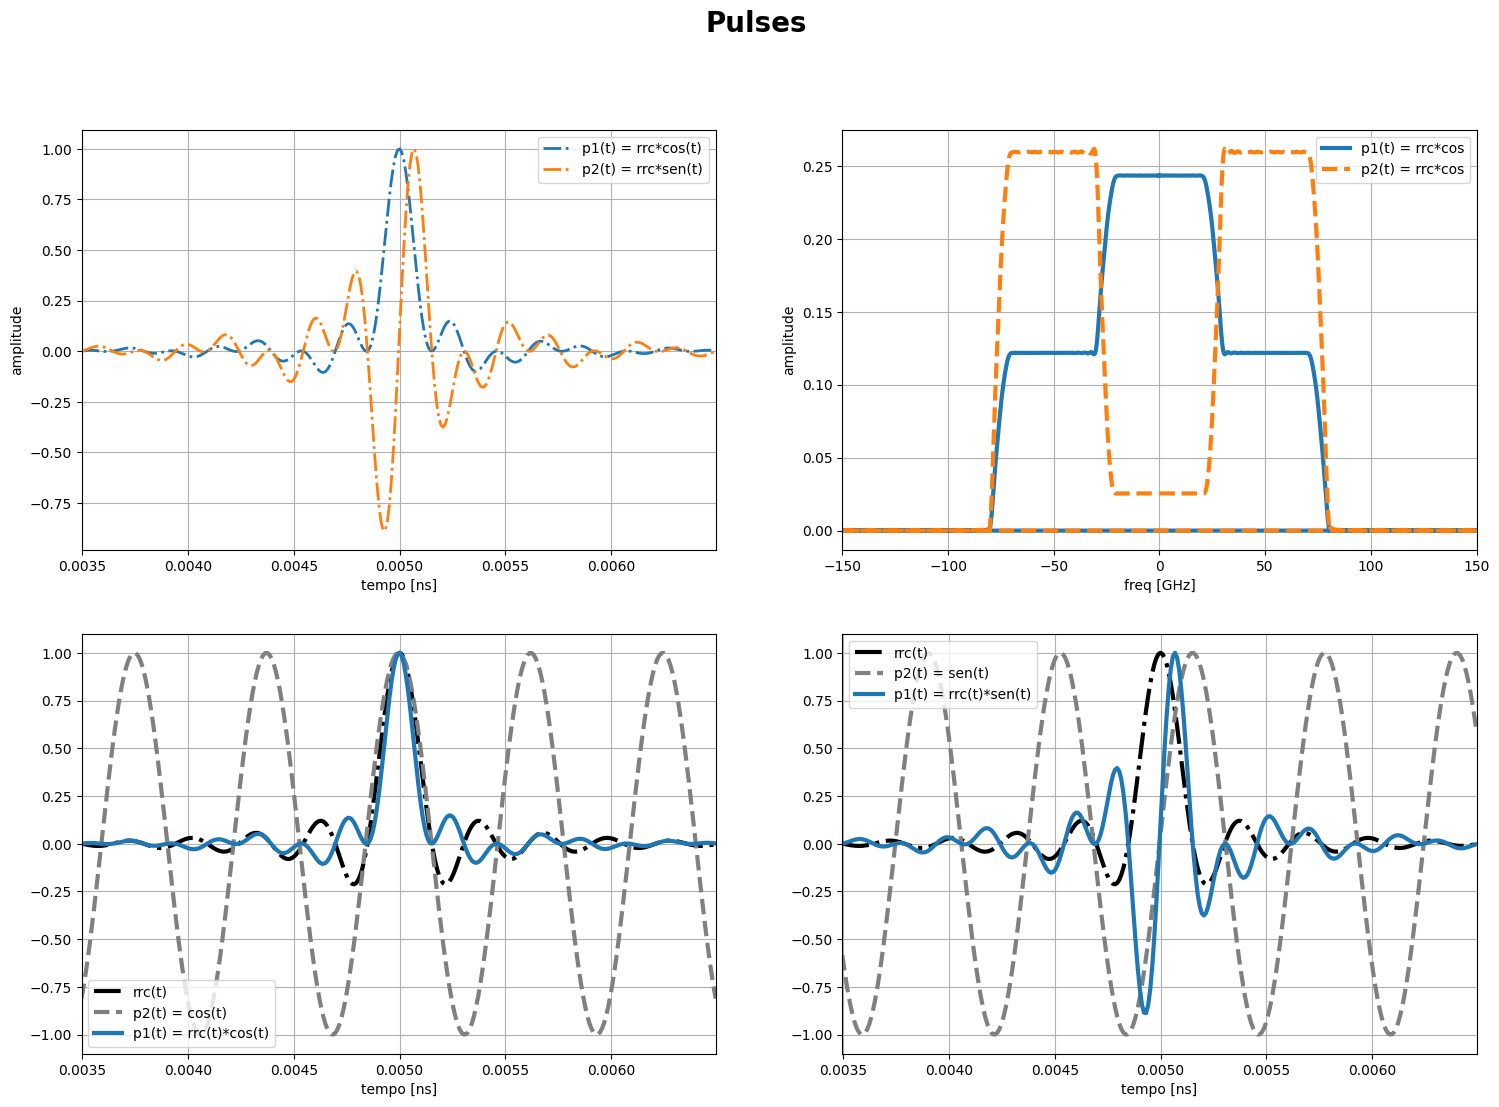

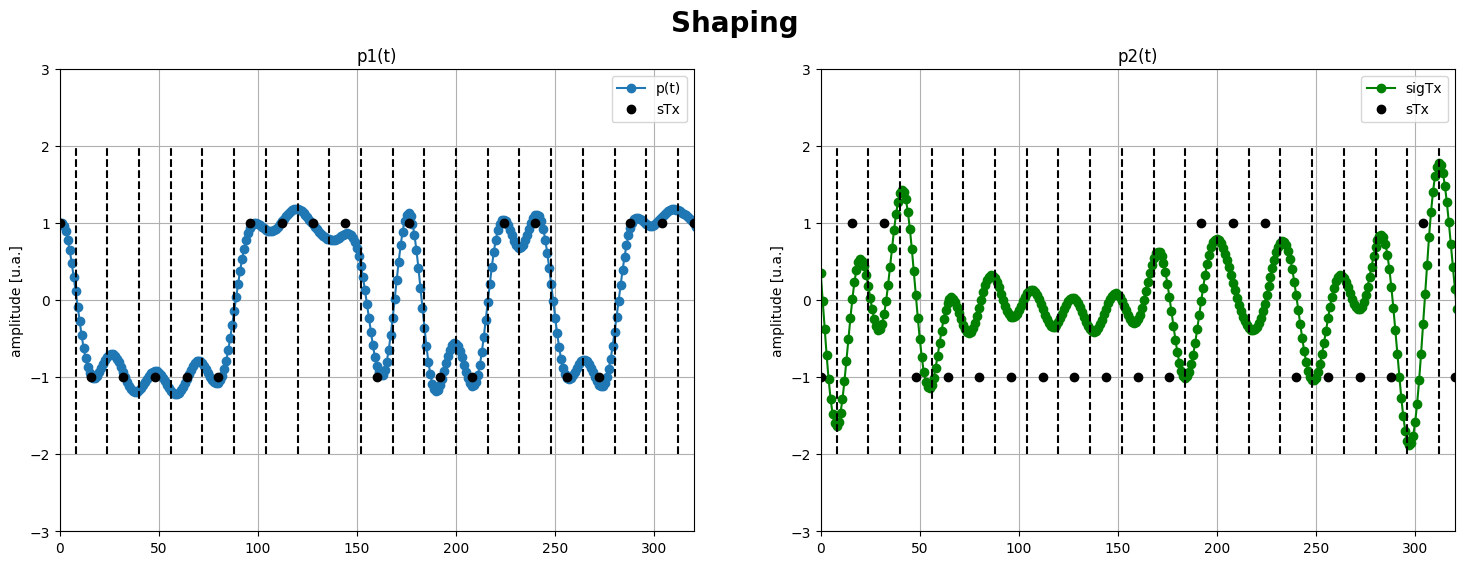

In [50]:
# pulso cosseno levantado (raised cosine)
Ncoeffs = 1024
rolloff1 = 0.1
rolloff2 = 0.1
fftSize = 2**12 # FFT Size

x = np.linspace(0,Ts,Ncoeffs)

senoid1 = cos(x,16*Rs,0)
senoid2 = cos(x,16*Rs,-90)

pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff1, Ts)
pulse1RRC = pulse1/np.max(np.abs(pulse1))
pulse1 = (pulse1*senoid1)/np.max(np.abs(pulse1*senoid1))
pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff2, Ts)
pulse2RRC = pulse2/np.max(np.abs(pulse2))
pulse2 = (pulse2*senoid2)/np.max(np.abs(pulse2*senoid2))

t = np.arange(pulse1.size)*Ts*1e9/Ncoeffs

fig, ax= plt.subplots(2,2,figsize=(18,12))
fig.suptitle(f'Pulses', fontsize=20, fontweight='bold')
ax[0][0].plot(t, pulse1,'-.', label = 'p1(t) = rrc*cos(t)', linewidth=2)
ax[0][0].plot(t, pulse2,'-.', label = 'p2(t) = rrc*sen(t)', linewidth=2)
ax[0][0].set_xlabel('tempo [ns]')
ax[0][0].set_ylabel('amplitude')
ax[0][0].set_xlim(max(t)*0.35, max(t)*0.65)
ax[0][0].grid()
ax[0][0].legend()

freq = np.fft.fftfreq(fftSize)*Fa
ax[0][1].plot(freq*1e-9, np.abs(np.fft.fft(pulse1,fftSize))/(len(pulse1)/SpS),'-', label = 'p1(t) = rrc*cos', linewidth=3)
ax[0][1].plot(freq*1e-9, np.abs(np.fft.fft(pulse2,fftSize))/(len(pulse2)/SpS),'--', label = 'p2(t) = rrc*cos', linewidth=3)
ax[0][1].set_xlabel('freq [GHz]')
ax[0][1].set_ylabel('amplitude')
ax[0][1].set_xlim(-1.5/(Ts*1e9),1.5/(Ts*1e9))
ax[0][1].grid()
ax[0][1].legend()

ax[1][0].plot(t, pulse1RRC,'-.', label = 'rrc(t)', linewidth=3, color='black')
ax[1][0].plot(t, senoid1,'--', label = 'p2(t) = cos(t)', linewidth=3, color='grey')
ax[1][0].plot(t, pulse1,'-', label = 'p1(t) = rrc(t)*cos(t)', linewidth=3)
ax[1][0].set_xlim(max(t)*0.35, max(t)*0.65)
ax[1][0].set_xlabel('tempo [ns]')
ax[1][0].legend()
ax[1][0].grid()

ax[1][1].plot(t, pulse2RRC,'-.', label = 'rrc(t)', linewidth=3, color='black')
ax[1][1].plot(t, senoid2,'--', label = 'p2(t) = sen(t)', linewidth=3, color='grey')
ax[1][1].plot(t, pulse2,'-', label = 'p1(t) = rrc(t)*sen(t)', linewidth=3)
ax[1][1].set_xlim(max(t)*0.35, max(t)*0.65)
ax[1][1].set_xlabel('tempo [ns]')
ax[1][1].legend()
ax[1][1].grid()

# formatação de pulso 
sigTx1 = firFilter(pulse1, symbolsUp.real)
sigTx2 = firFilter(pulse2, symbolsUp.imag)

fig, ax= plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f'Shaping', fontsize=20, fontweight='bold')
ax[0].plot(np.arange(0,len(sigTx1)), sigTx1,'-o', label = 'p(t)')
ax[0].plot(np.arange(0,len(sigTx1), SpS), sTx1,'ko', label = 'sTx', color='black')
ax[0].set_ylabel('amplitude [u.a.]')
ax[0].set_xlim(0,20*SpS)
ax[0].set_ylim(-3*max(choiceArray),3*max(choiceArray))
ax[0].set_title('p1(t)')
ax[0].grid()
ax[0].legend()

t = (0.5*SpS + np.arange(0, NumAm*SpS, SpS))
ax[0].vlines(t, -N, N, linestyles='dashed', color = 'k');

ax[1].plot(np.arange(0,len(sigTx2)), sigTx2,'-o', label = 'sigTx', color='green')
ax[1].plot(np.arange(0,len(sigTx2), SpS), sTx2,'ko', label = 'sTx', color='black')
ax[1].set_ylabel('amplitude [u.a.]')
ax[1].set_xlim(0,20*SpS)
ax[1].set_ylim(-3*max(choiceArray),3*max(choiceArray))
ax[1].set_title('p2(t)')
ax[1].grid()
ax[1].legend()

t = (0.5*SpS + np.arange(0, NumAm*SpS, SpS))
ax[1].vlines(t, -N, N, linestyles='dashed', color = 'k');

display(Math('Pulse~Period = %5.2fns ~~~~~~ Symbol~Frequency = %5.2fGHz'  %(Ts*1e9 , 1/(Ts*1e9))))

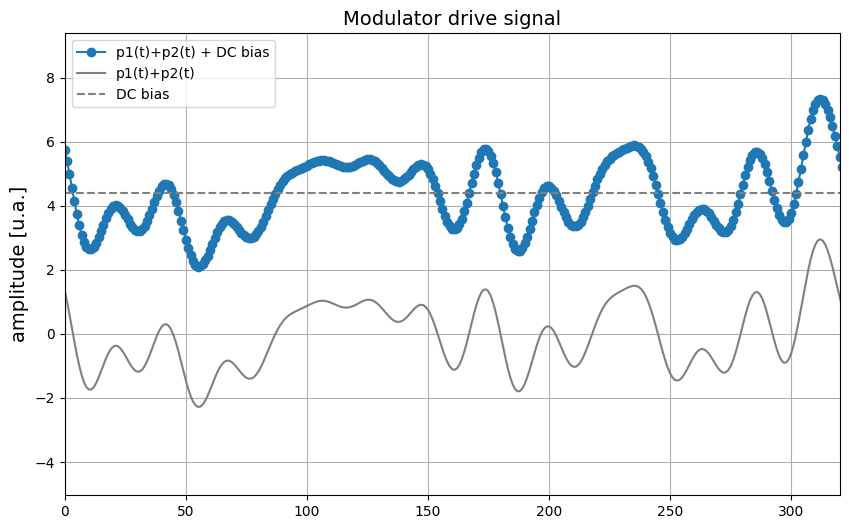

In [51]:
DCbias = -1*min(sigTx1+sigTx2)
sigTxAll = sigTx1+sigTx2 + DCbias*np.ones(len(sigTx1))

plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(sigTx1)), sigTxAll,'-o', label = 'p1(t)+p2(t) + DC bias')
plt.plot(np.arange(0,len(sigTx1)), sigTx1+sigTx2,'-', label = 'p1(t)+p2(t)', color='grey')
plt.axhline(y = DCbias, color = 'grey', linestyle = '--', label='DC bias')
plt.ylabel('amplitude [u.a.]', fontsize=14)
plt.xlim(0,20*SpS)
plt.title('Modulator drive signal', fontsize=14)
plt.grid()
plt.legend()

## DML caracterization

<IPython.core.display.Math object>

(0.0, 1000.0)

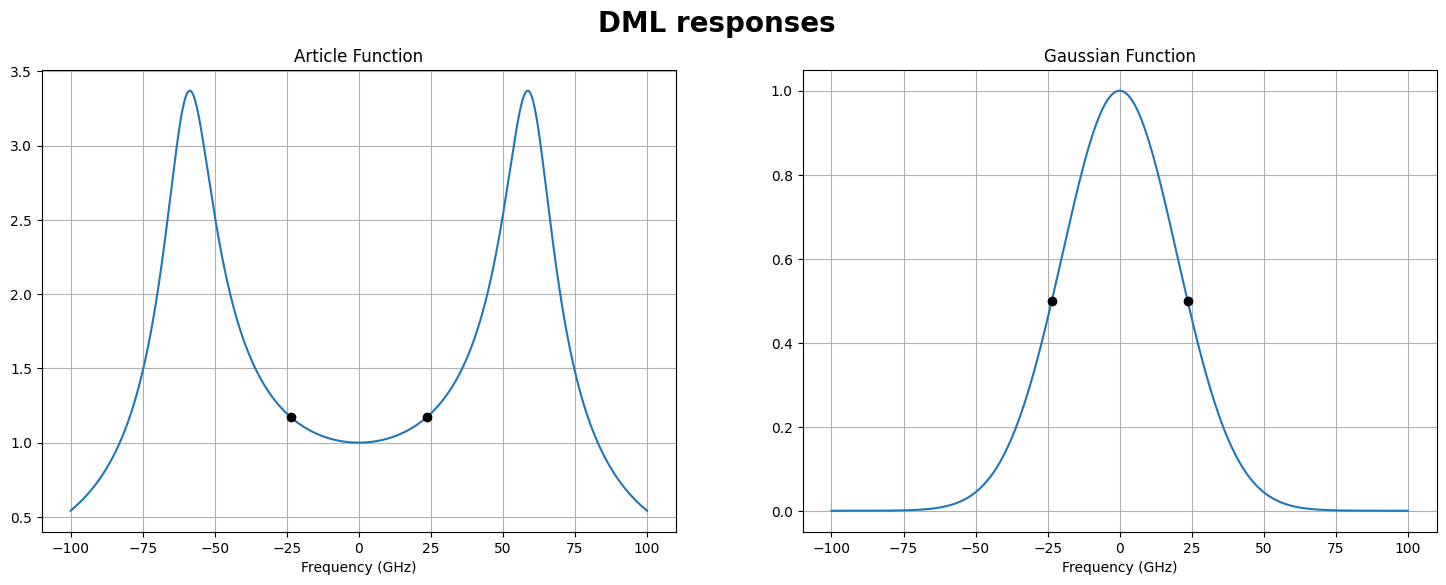

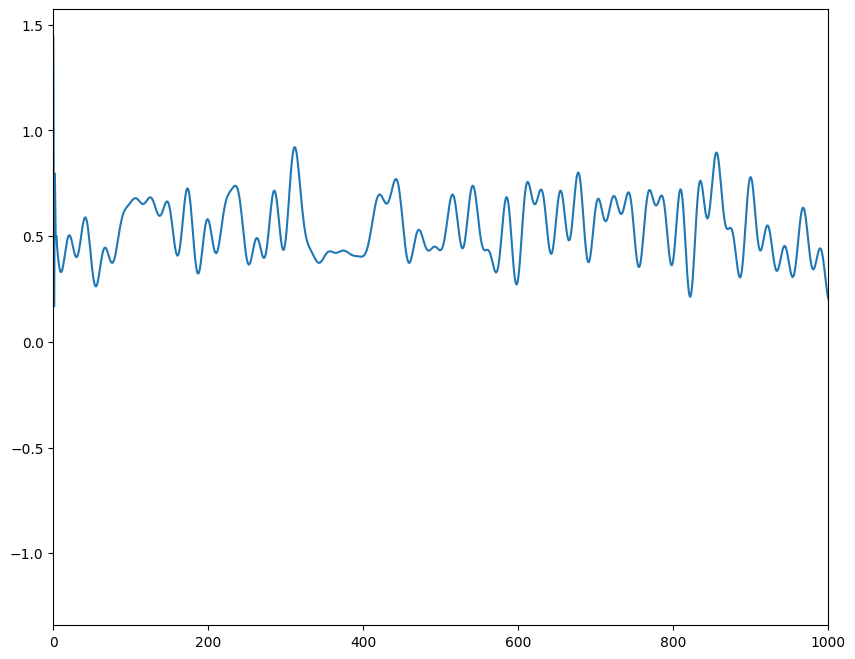

In [52]:
def DMLResponse(f, fr, yp):
    return np.sqrt(fr**4 / ( (f**2-fr**2)**2 + f**2*yp**2/(2*np.pi**2) ))

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

fr = 60e9
yp = 80e9
freqArray = np.linspace(-100e9,100e9,20000)

DML3db_Band = np.sqrt( (-(yp/(2*np.pi))**2 + 2*fr**2 + np.sqrt((yp/2*np.pi)**4 - 4*(yp/2*np.pi)**2*fr**2 + 8*fr**4) ) /2 )  # DML 3db direct modulation Bandwidth
DMLFunc = DMLResponse(freqArray,fr,yp)
DMLGauss = gaussian(freqArray, 0e9, 20e9)

fig, ax= plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f'DML responses', fontsize=20, fontweight='bold')
ax[0].plot(freqArray*1e-9,DMLFunc)
ax[0].set_title('Article Function')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].grid()

halfwid, a, fmin, fmax = fwhm(freqArray, DMLFunc, 3)
halfwid2, a, fmin, fmax = fwhm(freqArray, DMLGauss, 3)
display(Math('f_{3~db~article~analytic} = %5.2fGHz ~~~~~~ f_{3~db~article} = %5.2fGHz~~~~~~f_{3~db~gauss} = %5.2fGHz'  
             %(DML3db_Band*1e-9,halfwid*1e-9,halfwid2*1e-9)))
ax[0].plot(freqArray[fmin]*1e-9,DMLFunc[fmin], 'ko')
ax[0].plot(freqArray[fmax]*1e-9,DMLFunc[fmax], 'ko')

ax[1].plot(freqArray*1e-9, DMLGauss)
ax[1].set_title('Gaussian Function')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].grid()
ax[1].plot(freqArray[fmin]*1e-9,DMLGauss[fmin], 'ko')
ax[1].plot(freqArray[fmax]*1e-9,DMLGauss[fmax], 'ko')    

DMLGaussTime = np.fft.ifft(DMLGauss)
sigTxDml = np.convolve(DMLGaussTime,sigTxAll,mode='full')
plt.figure(figsize=(10,8))
plt.plot(sigTxDml)
plt.xlim(0,1000)

## Fotodiode reception

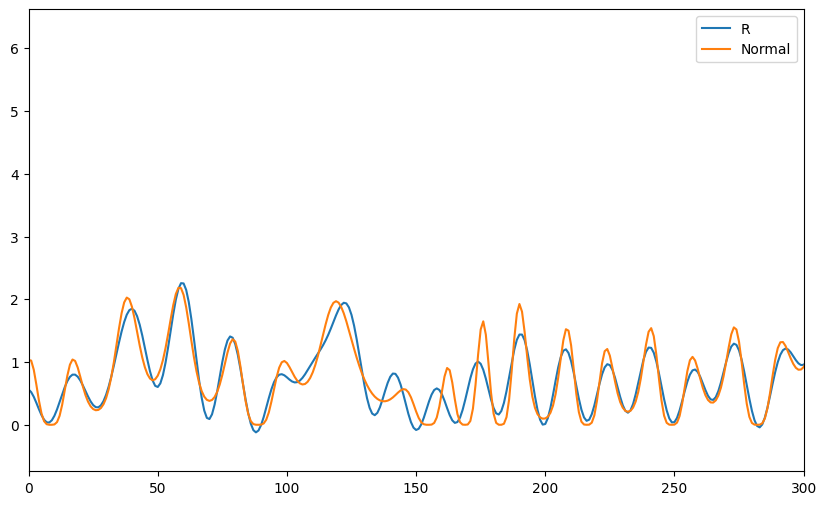

In [75]:
sigTxo = np.abs(sigTx1)**2

# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fa

I_Rx = photodiode(sigTxo, paramPD)

discard = 1000

plt.figure(figsize=(10,6))
plt.plot(I_Rx, label='R')
plt.plot(I_Rx_ideal, label='Normal')
plt.xlim(0,300)
plt.legend()

## Correlator

In [33]:
def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]


1024
160000
1.9004937707844147
0.6725378601621487
(1.453087682169415e-05+4.5025961698474116e-20j)


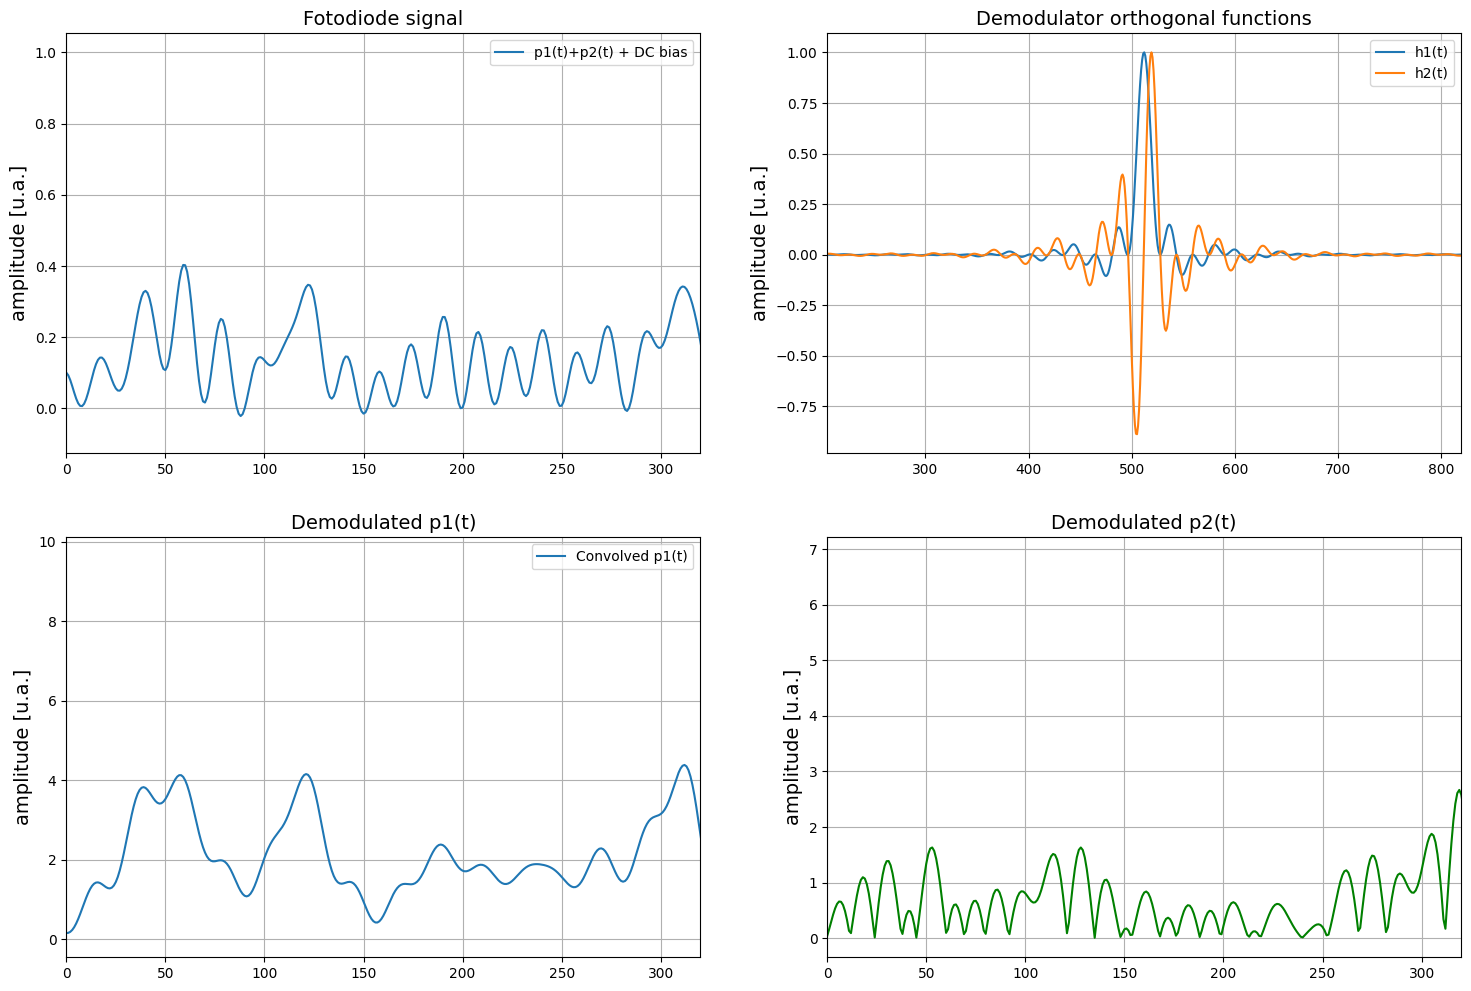

In [76]:
sigTxo = I_Rx/max(I_Rx)

fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0][0].plot(np.arange(0,len(sigTxo)), sigTxo,'-', label = 'p1(t)+p2(t) + DC bias')
ax[0][0].set_ylabel('amplitude [u.a.]', fontsize=14)
ax[0][0].set_xlim(0,20*SpS)
ax[0][0].set_title('Fotodiode signal', fontsize=14)
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].plot(np.arange(0,len(pulse1)), pulse1,'-', label = 'h1(t)')
ax[0][1].plot(np.arange(0,len(pulse2)), pulse2,'-', label = 'h2(t)')
ax[0][1].set_ylabel('amplitude [u.a.]', fontsize=14)
ax[0][1].set_title('Demodulator orthogonal functions', fontsize=14)
ax[0][1].grid()
ax[0][1].set_xlim(len(pulse1)*0.2,len(pulse1)*0.8)
ax[0][1].legend()

conv1 = filterNoDelay(pulse1,sigTxo)
conv2 = filterNoDelay(pulse2[::-1],sigTxo)

print(len(pulse1))
print(len(sigTxo))

ax[1][0].plot(np.arange(0,len(conv1)), conv1,'-', label = 'Convolved p1(t)')
#ax[1][0].plot(np.arange(0,len(sigTx1), SpS), np.average(abs(conv1))+sTx1,'ko', label = 'sTx', color='black')
ax[1][0].set_ylabel('amplitude [u.a.]', fontsize=14)
ax[1][0].set_xlim(0,20*SpS)
ax[1][0].set_title('Demodulated p1(t)', fontsize=14)
ax[1][0].grid()
ax[1][0].legend()

ax[1][1].plot(np.arange(0,len(conv2)), abs(conv2),'-', label = 'Convolved p2(t)', color='green')
#ax[1][1].plot(np.arange(0,len(sigTx2), SpS), sTx2,'ko', label = 'sTx', color='black')
ax[1][1].set_ylabel('amplitude [u.a.]', fontsize=14)
ax[1][1].set_xlim(0,20*SpS)
ax[1][1].set_title('Demodulated p2(t)', fontsize=14)
ax[1][1].grid()
ax[1][1].legend

print(np.average(abs(conv1)))
print(np.average(abs(conv2)))
print(np.average(sigTxDml))

## Optical test transmission

$$\begin{equation}
A_{\text {out}}(t) = A_{i n}(t) \cos \left(\frac{1}{2V_{\pi}}[u(t)+V_b]\pi\right)
\end{equation}$$

C:\Users\Caio\AppData\Local\Temp\ipykernel_16840\1276151187.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(ux,np.cos(np.pi*(ux+Vb)/(2*Vπ)), 'ko', color='red')
C:\Users\Caio\AppData\Local\Temp\ipykernel_16840\1276151187.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[1].plot(up,np.cos(np.pi*(up+Vb)/(2*Vπ)), 'ko', color='red')


3.2539568672798422
-1.6269784336399211


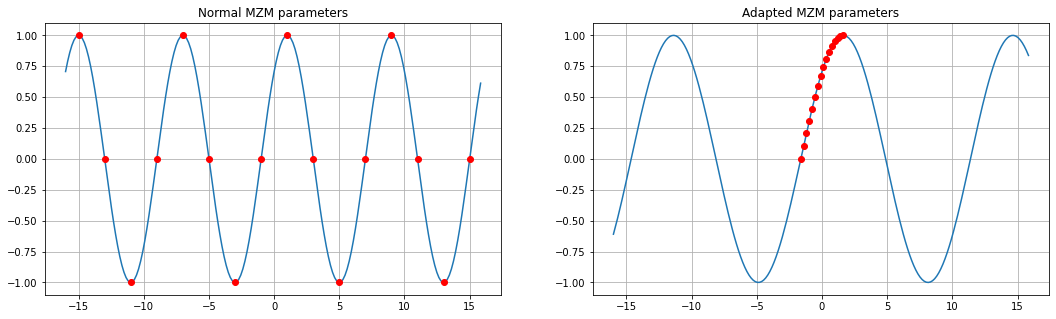

In [141]:
N = 16 # N-PAM
NumAm = 10000 # Número de símbolos
NumPts = 30 # Número de pontos

# Parâmetros MZM
Vπ = 2
Vb = -Vπ/2

SpS = 32 # Samples per symbol

# pulso cosseno levantado (raised cosine)
Ncoeffs = 240
rolloff = 0.01
fftSize = 2**12 # FFT Size

Rs     = 100e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

fig, ax= plt.subplots(1,2,figsize=(18,5))
u = np.arange(-N,N,N/100)
ux= np.arange(-N+1,N,2)
ax[0].plot(u,np.cos(np.pi*(u+Vb)/(2*Vπ)))
ax[0].plot(ux,np.cos(np.pi*(ux+Vb)/(2*Vπ)), 'ko', color='red')
ax[0].set_title('Normal MZM parameters')
ax[0].grid()

up = pnorm(ux)
Vπ = Vπ*(up[int(N/2 - 1)]/ux[int(N/2 - 1)])*max(ux)
Vb = max(ux)*(up[int(N/2 - 1)]/ux[int(N/2 - 1)])-Vπ

ax[1].plot(u,np.cos(np.pi*(u+Vb)/(2*Vπ)))
ax[1].plot(up,np.cos(np.pi*(up+Vb)/(2*Vπ)), 'ko', color='red')
ax[1].set_title('Adapted MZM parameters')
ax[1].grid()
print(Vπ)
print(Vb)

C:\Users\Caio\AppData\Local\Temp\ipykernel_16840\1373650861.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(np.arange(0,len(sigTx1), SpS), sTx1,'ko', label = 'sTx', color='black')
C:\Users\Caio\AppData\Local\Temp\ipykernel_16840\1373650861.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[1].plot(np.arange(0,len(sigTx2), SpS), sTx2,'ko', label = 'sTx', color='black')


Total time: 100.0ns


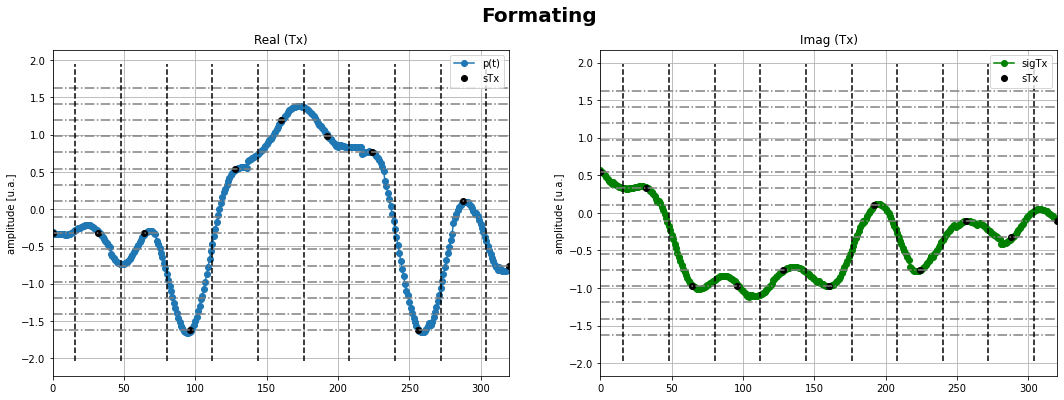

In [142]:
choiceArray = pnorm(np.arange(-N+1,N,2))
sTx1 = np.random.choice(choiceArray, NumAm) # Subchannel 1
sTx2 = np.random.choice(choiceArray, NumAm) # Subchannel 2
sTx = sTx1 + 1j*sTx2 # Complex representation of subchannels

# upsampling
symbolsUp = upsample(sTx, SpS)

x = np.linspace(-Ta,Ta,Ncoeffs)
pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse1 = pulse1/np.max(np.abs(pulse1))
pulse1 = (np.multiply(pulse1,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse1,cos(x,Fa,0))))
pulse2 = pulseShape('rrc', SpS, Ncoeffs, 10*rolloff, Ta)
#pulse2 = pulse2/np.max(np.abs(pulse2))
pulse2 = (np.multiply(pulse2,cos(x,2*Fa,0)))/np.max(np.abs(np.multiply(pulse2,cos(x,2*Fa,0))))

x = np.linspace(-Ta,Ta,Ncoeffs)
pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff1, Ta)
#pulse1 = pulse1/np.max(np.abs(pulse1))
pulse1 = (np.multiply(pulse1,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse1,cos(x,Fa,0))))
pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff2, Ta)
#pulse2 = pulse2/np.max(np.abs(pulse2))
pulse2 = (np.multiply(pulse2,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse2,cos(x,Fa,0))))

# formatação de pulso 
sigTx1 = firFilter(pulse1, symbolsUp.real)
sigTx2 = firFilter(pulse2, symbolsUp.imag)

fig, ax= plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f'Formating', fontsize=20, fontweight='bold')
ax[0].plot(np.arange(0,len(sigTx1)), sigTx1,'-o', label = 'p(t)')
ax[0].plot(np.arange(0,len(sigTx1), SpS), sTx1,'ko', label = 'sTx', color='black')
ax[0].set_ylabel('amplitude [u.a.]')
ax[0].set_xlim(0,10*SpS)
for i in range(choiceArray.size):
    ax[0].axhline(y = choiceArray[i], color = 'grey', linestyle = '-.')
ax[0].set_title('Real (Tx)')
ax[0].grid()
ax[0].legend()

t = (0.5*SpS + np.arange(0, NumAm*SpS, SpS))
ax[0].vlines(t, min(sigTx1), max(sigTx1), linestyles='dashed', color = 'k');

ax[1].plot(np.arange(0,len(sigTx2)), sigTx2,'-o', label = 'sigTx', color='green')
ax[1].plot(np.arange(0,len(sigTx2), SpS), sTx2,'ko', label = 'sTx', color='black')
ax[1].set_ylabel('amplitude [u.a.]')
ax[1].set_xlim(0,10*SpS)
for i in range(choiceArray.size):
    ax[1].axhline(y = choiceArray[i], color = 'grey', linestyle = '-.')
ax[1].set_title('Imag (Tx)')
ax[1].grid()
ax[1].legend()

t = (0.5*SpS + np.arange(0, NumAm*SpS, SpS))
ax[1].vlines(t, min(sigTx2), max(sigTx2), linestyles='dashed', color = 'k');

Pi_dBm = -5             # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# modulação óptica
Ai = np.sqrt(Pi)*np.ones(np.size(sigTx1))
sigTxo = mzm(Ai, sigTx1, Vπ, Vb)

# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

print(f'Total time: {Ts*NumAm*1e9}ns')

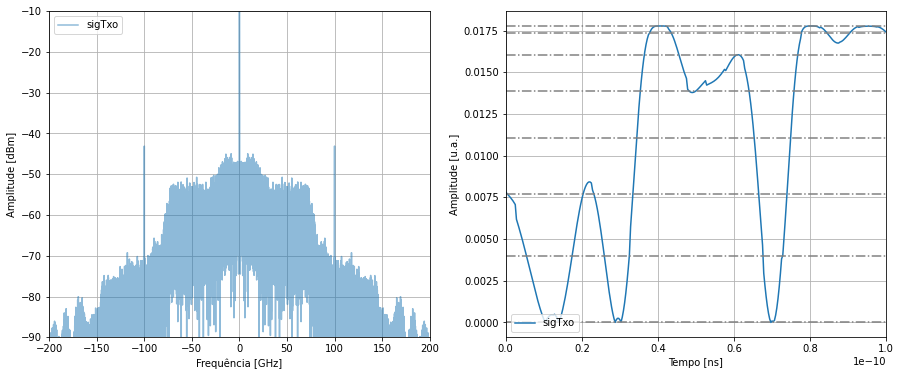

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-90,-10)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

limiarY = max(sigTxo)*np.cos(np.pi*(choiceArray+Vb)/(2*Vπ))

axs[1].plot(np.linspace(0,Ts*NumAm,NumAm*SpS), abs(sigTxo), label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
for i in range(choiceArray.size):
    axs[1].axhline(y = limiarY[i], color = 'grey', linestyle = '-.')
axs[1].set_xlim(0,10*Ts)
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

In [10]:
from scipy.special import erfc

def ifBetween(num, lim1, lim2):
    if(num > lim1 and num < lim2):
        return True
    else:
        return False

Pin[Rx] = -8.00 dBm 
SNR[sim] = 18.35 dB 

IdArray: [0.00993266 0.22686312 0.44379358 0.66072403 0.87765449 1.09458495
 1.31151541 1.52844587 1.74537632 1.96230678 2.17923724 2.3961677
 2.61309815 2.83002861 3.04695907]
Total de erros contados = 6705
BER = 6.70e-01  


C:\Users\Caio\AppData\Local\Temp\ipykernel_16840\107898460.py:136: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[2][0].plot(np.arange(0,len(I_Rx),SpS), np.std(I_RxNorm)*sTx1+np.average(I_RxNorm),'ko', label = 'sTx1', color='black')


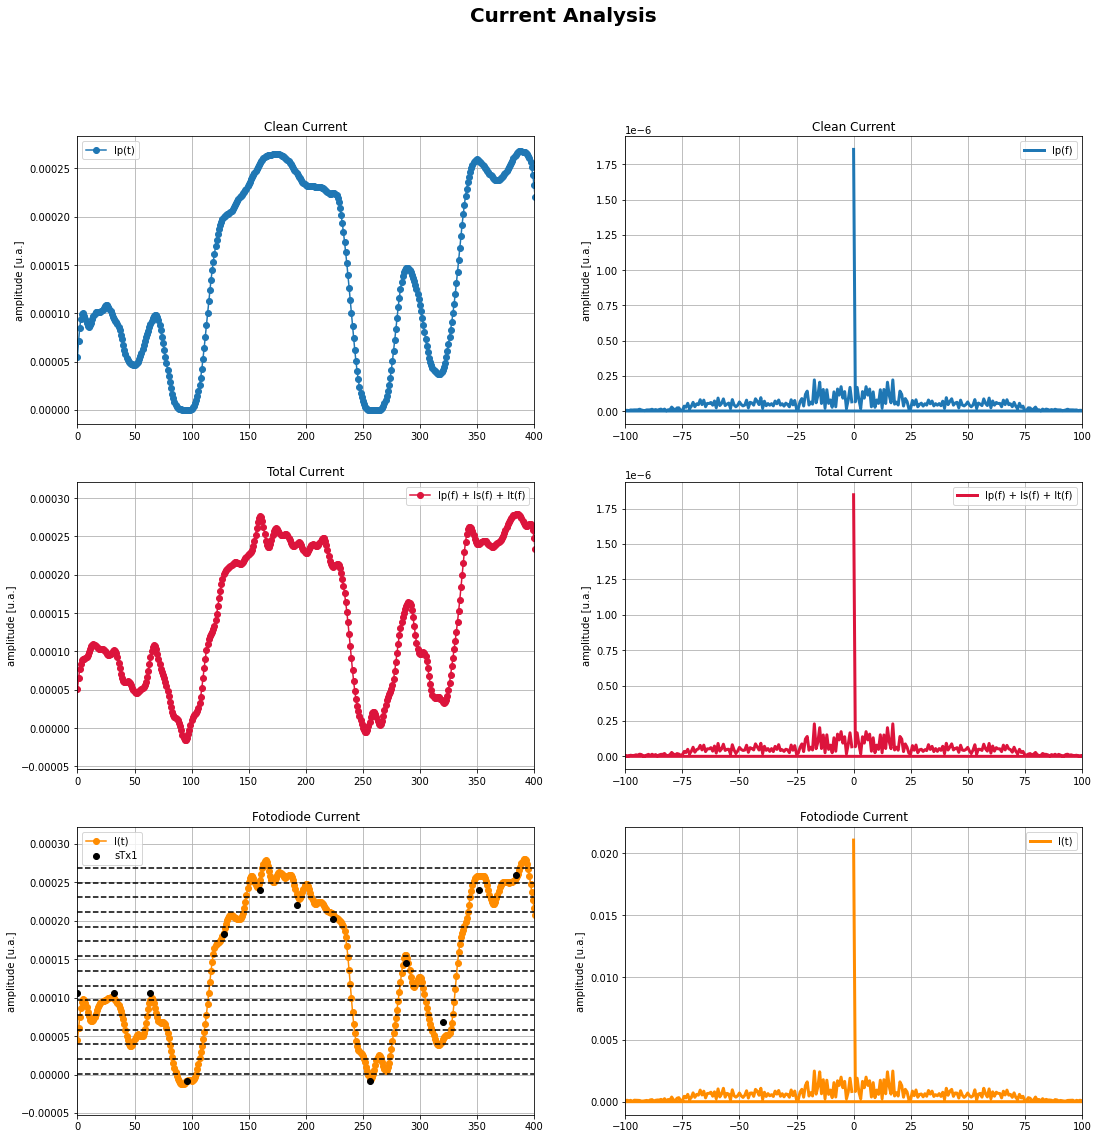

In [143]:
### Receptor
Pin = (np.abs(sigTxo)**2).mean()

# parâmetros do receptor
Tc  = 25    # temperatura em Celsius
Rd  = 0.85  # responsividade em A/W
Id  = 5e-9  # corrente de escuro em nA
RL  = 50    # RL em Ohms
B   = 300e9   # banda do receptor em Hz
kB  = constants.value('Boltzmann constant')
q  = constants.value('elementary charge')

# ruído térmico
T = Tc + 273.15     # temperatura em Kelvin
σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

# detecta o sinal com o fotodiodo pin (modelo implementado no OptiCommPy)
paramPD = parameters()
paramPD.R = Rd         # responsividade em A/W
paramPD.Tc = Tc       # temperatura em Celsius
paramPD.Id = Id       # corrente de escuro em A
paramPD.RL = RL       # RL em Ohms
paramPD.B = B         # Largura de banda Hz
paramPD.Fs = Fa 
paramPD.ideal = False

I_RxNorm = photodiode(sigTxo, paramPD)
I_Rx = I_RxNorm/np.std(I_RxNorm)

############ calculando a SNR na simulação

# ruído de disparo 
σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

# fotocorrente livre de ruído
Ip = Rd*np.abs(sigTxo)**2

# ruído do receptor p-i-n aos sinais
Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

# filtragem Rx
Nfilt = 8001
h = lowPassFIR(B, Fa, Nfilt, typeF='rect')
#h = pulseShape('nrz', SpS)

Ip_Rx  = firFilter(h, Ip)
Is_Rx  = firFilter(h, Is)
It_Rx  = firFilter(h, It)

# SNR estimada numericamente na simulação
SNR_est = np.var(Ip_Rx)/(np.var(Is_Rx) + np.var(It_Rx))

print('Pin[Rx] = %.2f dBm '%(10*np.log10(Pin/1e-3)))
print('SNR[sim] = %.2f dB \n'%(10*np.log10(SNR_est)))

# captura amostras no meio dos intervalos de sinalização
I_RxAm = I_Rx[0::SpS]

# obtém estatísticas do sinal recebido

# I1 = np.mean(I_RxAm[sTx1==1]) # valor médio de I1
# I0 = np.mean(I_RxAm[sTx1==-1]) # valor médio de I0

# σ1 = np.std(I_RxAm[sTx1==1]) # desvio padrão σ1 de I1 
# σ0 = np.std(I_RxAm[sTx1==-1]) # desvio padrão σ0 de I0 

# Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # limiar de decisão ótimo
# Q  = (I1-I0)/(σ1 + σ0)         # fator Q

# # Aplica a regra de decisão ótima
# bitsRx = np.empty(sTx1.size)
# bitsRx[I_RxAm >  Id] = 1
# bitsRx[I_RxAm <= Id] = 0

# discard = 10
# err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], sTx1[discard:sTx1.size-discard])
# BER = np.mean(err)

# Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
# print('Pb = %.2e  '%(Pb))
# print('Total de erros contados = %d  '%(err.sum()))

IdArray = np.zeros(N-1)
for i in range(N-1):
    IdArray[i] = np.average([choiceArray[i+1],choiceArray[i]]) + np.average(I_RxAm)
print(f'IdArray: {IdArray}')

IdArray = np.pad(IdArray,(1,1),'constant', constant_values=(-10*N, 10*N))
check = 0
for i in range(IdArray.size - 1):
    for j in range(sTx1.size):
        if(ifBetween(I_RxAm[j], IdArray[i], IdArray[i+1]) and sTx1[j]==choiceArray[i]):
            check = check + 1

BER = (sTx1.size-check)/sTx1.size

Q  = np.arange(1, 11.1, 0.1)
Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
print(f'Total de erros contados = {sTx1.size-check}')
print('BER = %.2e  '%(BER))

freq = np.fft.fftfreq(fftSize)*Fa

fig, ax= plt.subplots(3,2,figsize=(18,18))
fig.suptitle(f'Current Analysis', fontsize=20, fontweight='bold')
ax[0][0].plot(np.arange(0,len(Ip_Rx)), Ip_Rx,'-o', label = 'Ip(t)')
ax[0][0].set_ylabel('amplitude [u.a.]')
ax[0][0].set_xlim(0,4e2)
ax[0][0].set_title('Clean Current')
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].plot(freq*1e-9, np.abs(np.fft.fft(Ip_Rx,fftSize))/len(Ip_Rx),'-', label = 'Ip(f)', linewidth=3)
ax[0][1].set_ylabel('amplitude [u.a.]')
ax[0][1].set_xlim(-1e2,1e2)
ax[0][1].set_title('Clean Current')
ax[0][1].grid()
ax[0][1].legend()

ax[1][0].plot(np.arange(0,len(Ip_Rx)), Ip_Rx+Is_Rx+It_Rx,'-o', label = 'Ip(f) + Is(f) + It(f)', color='crimson')
ax[1][0].set_ylabel('amplitude [u.a.]')
ax[1][0].set_xlim(0,4e2)
ax[1][0].set_title('Total Current')
ax[1][0].grid()
ax[1][0].legend()

ax[1][1].plot(freq*1e-9, np.abs(np.fft.fft(Ip_Rx+Is_Rx+It_Rx,fftSize))/len(Ip_Rx),'-', label = 'Ip(f) + Is(f) + It(f)', linewidth=3, color='crimson')
ax[1][1].set_ylabel('amplitude [u.a.]')
ax[1][1].set_xlim(-1e2,1e2)
ax[1][1].set_title('Total Current')
ax[1][1].grid()
ax[1][1].legend()

ax[2][0].plot(np.arange(0,len(I_Rx)), I_RxNorm,'-o', label = 'I(t)', color='darkorange')
ax[2][0].plot(np.arange(0,len(I_Rx),SpS), np.std(I_RxNorm)*sTx1+np.average(I_RxNorm),'ko', label = 'sTx1', color='black')
#ax[2][0].plot(np.arange(0,len(I_Rx),SpS), sTx1+np.average(I_RxAm),'ko', label = 'sTx1', color='black')
for i in range(IdArray.size-2):
    ax[2][0].axhline(y = np.std(I_RxNorm)*IdArray[i+1], color = 'black', linestyle = '--')
ax[2][0].set_ylabel('amplitude [u.a.]')
ax[2][0].set_xlim(0,4e2)
ax[2][0].set_title('Fotodiode Current')
ax[2][0].grid()
ax[2][0].legend()

ax[2][1].plot(freq*1e-9, np.abs(np.fft.fft(I_Rx,fftSize))/len(I_Rx),'-', label = 'I(t)', linewidth=3, color='darkorange')
ax[2][1].set_ylabel('amplitude [u.a.]')
ax[2][1].set_xlim(-1e2,1e2)
ax[2][1].set_title('Fotodiode Current')
ax[2][1].grid()
ax[2][1].legend()

# Modulation order analysis

Progress: 40/40


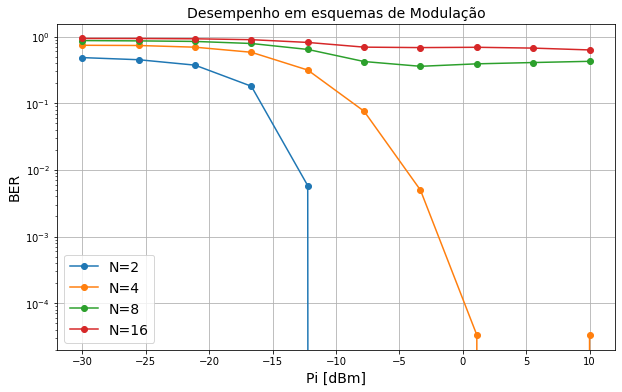

In [23]:
NArray = [2,4,8,16] # N-PAM Array
NumAm = 30000 # Número de símbolos
NumPts = 10 # Número de pontos
SpS = 32 # Samples per symbol

Rs  = 100e9  # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# pulso cosseno levantado (raised cosine)
Ncoeffs = 240
rolloff = 0.01
fftSize = 2**12 # FFT Size

Pi_dBmArray = np.linspace(-30,10,NumPts)      # Array da potência de sinal óptico na entrada do modulador em dBm

BERArray = np.zeros((NumPts,NumPts))

x = np.linspace(-Ta,Ta,Ncoeffs)
pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse1 = pulse1/np.max(np.abs(pulse1))
pulse1 = (np.multiply(pulse1,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse1,cos(x,Fa,0))))
pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse2 = pulse2/np.max(np.abs(pulse2))
pulse2 = (np.multiply(pulse2,cos(x,2*Fa,0)))/np.max(np.abs(np.multiply(pulse2,cos(x,2*Fa,0))))

# parâmetros do receptor
Tc  = 25    # temperatura em Celsius
Rd  = 0.85  # responsividade em A/W
Id  = 5e-9  # corrente de escuro em nA
RL  = 50    # RL em Ohms
B   = 300e9   # banda do receptor em Hz
kB  = constants.value('Boltzmann constant')
q  = constants.value('elementary charge')

# detecta o sinal com o fotodiodo pin (modelo implementado no OptiCommPy)
paramPD = parameters()
paramPD.R = Rd         # responsividade em A/W
paramPD.Tc = Tc       # temperatura em Celsius
paramPD.Id = Id       # corrente de escuro em A
paramPD.RL = RL       # RL em Ohms
paramPD.B = B         # Largura de banda Hz
paramPD.Fs = Fa 
paramPD.ideal = False

for k in range(len(NArray)):
    for l in range(NumPts):

        N = NArray[k]

        Pi_dBm = Pi_dBmArray[l]   # potência de sinal óptico na entrada do modulador em dBm
        Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

        # Parâmetros MZM
        Vπ = 2
        Vb = -Vπ/2

        # ruído térmico
        T = Tc + 273.15     # temperatura em Kelvin

        ux = np.arange(-N+1,N,2)

        choiceArray = pnorm(ux)
        sTx1 = np.random.choice(choiceArray, NumAm) # Subchannel 1
        sTx2 = np.random.choice(choiceArray, NumAm) # Subchannel 2
        sTx = sTx1 + 1j*sTx2 # Complex representation of subchannels

        Vπ = Vπ*(choiceArray[int(N/2 - 1)]/ux[int(N/2 - 1)])*max(ux)
        Vb = max(ux)*(choiceArray[int(N/2 - 1)]/ux[int(N/2 - 1)])-Vπ

        # upsampling
        symbolsUp = upsample(sTx, SpS)

        # formatação de pulso 
        sigTx1 = firFilter(pulse1, symbolsUp.real)
        sigTx2 = firFilter(pulse2, symbolsUp.imag)

        # modulação óptica
        Ai = np.sqrt(Pi)*np.ones(np.size(sigTx1))
        sigTxo = mzm(Ai, sigTx1, Vπ, Vb)

        ### Receptor
        Pin = (np.abs(sigTxo)**2).mean()

        # ruído térmico
        σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

        I_Rx = photodiode(sigTxo, paramPD)
        I_Rx = I_Rx/np.std(I_Rx)

        ############ calculando a SNR na simulação

        # ruído de disparo 
        σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

        # fotocorrente livre de ruído
        Ip = Rd*np.abs(sigTxo)**2

        # ruído do receptor p-i-n aos sinais
        Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
        It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

        # filtragem Rx
        Nfilt = 8001
        h = lowPassFIR(B, Fa, Nfilt, typeF='rect')
        #h = pulseShape('nrz', SpS)

        Ip_Rx  = firFilter(h, Ip)
        Is_Rx  = firFilter(h, Is)
        It_Rx  = firFilter(h, It)

        # SNR estimada numericamente na simulação
        SNR_est = np.var(Ip_Rx)/(np.var(Is_Rx) + np.var(It_Rx))

        # captura amostras no meio dos intervalos de sinalização
        I_RxAm = I_Rx[0::SpS]

        # obtém estatísticas do sinal recebido
        IdArray = np.zeros(N-1)
        for i in range(N-1):
            IdArray[i] = np.average([choiceArray[i+1],choiceArray[i]]) + np.average(I_RxAm)
        #print(f'IdArray: {IdArray}')

        IdArray = np.pad(IdArray,(1,1),'constant', constant_values=(-10*N, 10*N))
        check = 0
        for i in range(IdArray.size - 1):
            for j in range(sTx1.size):
                if(ifBetween(I_RxAm[j], IdArray[i], IdArray[i+1]) and sTx1[j]==choiceArray[i]):
                    check = check + 1

        BER = (sTx1.size-check)/sTx1.size

        Q  = np.arange(1, 11.1, 0.1)
        Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
        # print(f'Total de erros contados = {sTx1.size-check}')
        # print('BER = %.2e  '%(BER))

        BERArray[k,l] = BER
        clear_output(wait=True)
        print(f'Progress: {(k*NumPts)+(l+1)}/{NumPts*len(NArray)}')

plt.figure(figsize=(10,6))
for i in range(len(NArray)):
    plt.semilogy(Pi_dBmArray,BERArray[i], '-o',  label=f'N={NArray[i]}')
plt.title('Desempenho em esquemas de Modulação',fontsize=14)
plt.xlabel('Pi [dBm]',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.legend(fontsize=14)
plt.grid()

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/BERxPi" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

In [48]:
def Qfunc(x):
    return 0.5 - 0.5*erfc(x/np.sqrt(2))

def SERPi(M, N, Rb, R, N0, Pi):
    return 2*(M-1)/M * Qfunc(np.sqrt( np.log2(M)/(N*(M-1)**2) * R**2*np.abs(Pi)**2/(Rb*N0)))

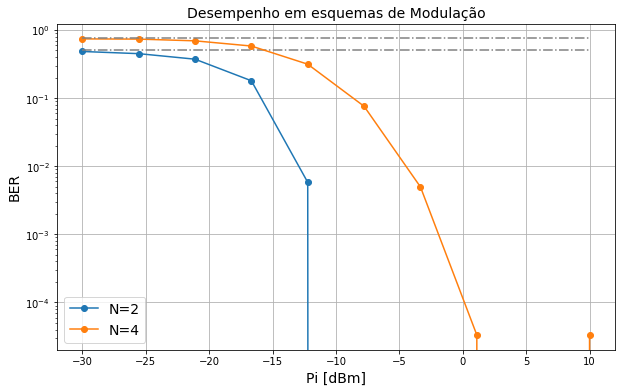

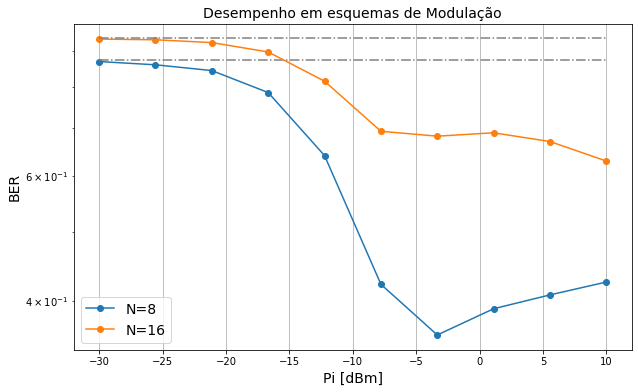

In [54]:
plt.figure(figsize=(10,6))
for i in range(2):
    plt.semilogy(Pi_dBmArray,BERArray[i], '-o',  label=f'N={NArray[i]}')
    plt.plot(Pi_dBmArray,SERPi(NArray[i], 1, Rs*np.log2(NArray[i]), Rd, σ2_T**2/2, Pi_dBmArray), color = 'grey', linestyle = '-.')
plt.title('Desempenho em esquemas de Modulação',fontsize=14)
plt.xlabel('Pi [dBm]',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.legend(fontsize=14)
plt.grid()

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/BERxPi" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

plt.figure(figsize=(10,6))
for i in range(2,len(NArray)):
    plt.semilogy(Pi_dBmArray,BERArray[i], '-o',  label=f'N={NArray[i]}')
    plt.plot(Pi_dBmArray,SERPi(NArray[i], 1, Rs*np.log2(NArray[i]), Rd, σ2_T**2/2, Pi_dBmArray), color = 'grey', linestyle = '-.')
plt.title('Desempenho em esquemas de Modulação',fontsize=14)
plt.xlabel('Pi [dBm]',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.legend(fontsize=14)
plt.grid()

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/BERxPi" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

# Pulse analysis

Progress: 10/10


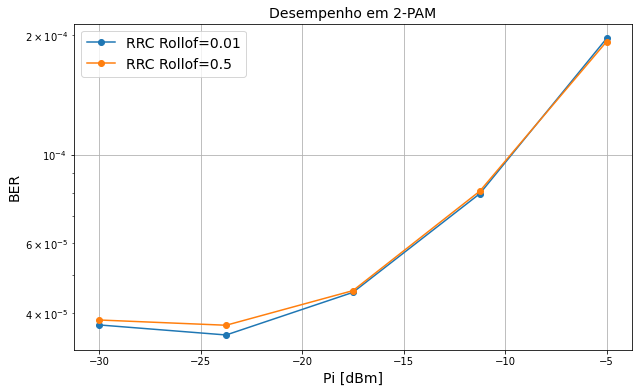

In [124]:
N = 2
NumAm = 20000 # Número de símbolos
NumPts = 5 # Número de pontos
SpS = 64 # Samples per symbol

Rs  = 100e9  # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# pulso cosseno levantado (raised cosine)
Ncoeffs = 1024
rolloffArray = np.linspace(0.01,0.5,2)
fftSize = 2**12 # FFT Size

Pi_dBmArray = np.linspace(-30,-5,NumPts)      # Array da potência de sinal óptico na entrada do modulador em dBm

BERArray = np.zeros((len(rolloffArray),NumPts))
DCArray = np.zeros((len(rolloffArray),NumPts))

x = np.linspace(-Ta,Ta,Ncoeffs)
pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse1 = pulse1/np.max(np.abs(pulse1))
pulse1 = (np.multiply(pulse1,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse1,cos(x,Fa,0))))
pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse2 = pulse2/np.max(np.abs(pulse2))
pulse2 = (np.multiply(pulse2,cos(x,2*Fa,0)))/np.max(np.abs(np.multiply(pulse2,cos(x,2*Fa,0))))

# parâmetros do receptor
Tc  = 25    # temperatura em Celsius
Rd  = 0.85  # responsividade em A/W
Id  = 5e-9  # corrente de escuro em nA
RL  = 50    # RL em Ohms
B   = 300e9   # banda do receptor em Hz
kB  = constants.value('Boltzmann constant')
q  = constants.value('elementary charge')

# detecta o sinal com o fotodiodo pin (modelo implementado no OptiCommPy)
paramPD = parameters()
paramPD.R = Rd         # responsividade em A/W
paramPD.Tc = Tc       # temperatura em Celsius
paramPD.Id = Id       # corrente de escuro em A
paramPD.RL = RL       # RL em Ohms
paramPD.B = B         # Largura de banda Hz
paramPD.Fs = Fa 
paramPD.ideal = False

for k in range(len(rolloffArray)):
    for l in range(NumPts):

        Pi_dBm = Pi_dBmArray[l]   # potência de sinal óptico na entrada do modulador em dBm
        Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

        # Parâmetros MZM
        Vπ = 2
        Vb = -Vπ/2

        # ruído térmico
        T = Tc + 273.15     # temperatura em Kelvin

        ux = np.arange(-N+1,N,2)

        choiceArray = pnorm(ux)
        sTx1 = np.random.choice(choiceArray, NumAm) # Subchannel 1
        sTx2 = np.random.choice(choiceArray, NumAm) # Subchannel 2
        sTx = sTx1 + 1j*sTx2 # Complex representation of subchannels

        Vπ = Vπ*(choiceArray[int(N/2 - 1)]/ux[int(N/2 - 1)])*max(ux)
        Vb = max(ux)*(choiceArray[int(N/2 - 1)]/ux[int(N/2 - 1)])-Vπ

        rolloff = rolloffArray[k]

        x = np.linspace(-Ta,Ta,Ncoeffs)
        pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
        #pulse1 = pulse1/np.max(np.abs(pulse1))
        pulse1 = (np.multiply(pulse1,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse1,cos(x,Fa,0))))
        pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
        #pulse2 = pulse2/np.max(np.abs(pulse2))
        pulse2 = (np.multiply(pulse2,cos(x,2*Fa,0)))/np.max(np.abs(np.multiply(pulse2,cos(x,2*Fa,0))))

        # upsampling
        symbolsUp = upsample(sTx, SpS)

        # formatação de pulso 
        sigTx1 = firFilter(pulse1, symbolsUp.real)
        sigTx2 = firFilter(pulse2, symbolsUp.imag)

        # modulação óptica
        Ai = np.sqrt(Pi)*np.ones(np.size(sigTx1))
        sigTxo = mzm(Ai, sigTx1, Vπ, Vb)

        ### Receptor
        Pin = (np.abs(sigTxo)**2).mean()

        # ruído térmico
        σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

        I_RxNorm = photodiode(sigTxo, paramPD)
        I_Rx = I_RxNorm/np.std(I_RxNorm)

        ############ calculando a SNR na simulação

        # ruído de disparo 
        σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

        # fotocorrente livre de ruído
        Ip = Rd*np.abs(sigTxo)**2

        # ruído do receptor p-i-n aos sinais
        Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
        It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

        # filtragem Rx
        Nfilt = 8001
        h = lowPassFIR(B, Fa, Nfilt, typeF='rect')
        #h = pulseShape('nrz', SpS)

        Ip_Rx  = firFilter(h, Ip)
        Is_Rx  = firFilter(h, Is)
        It_Rx  = firFilter(h, It)

        # SNR estimada numericamente na simulação
        SNR_est = np.var(Ip_Rx)/(np.var(Is_Rx) + np.var(It_Rx))

        # captura amostras no meio dos intervalos de sinalização
        I_RxAm = I_Rx[0::SpS]

        # obtém estatísticas do sinal recebido
        IdArray = np.zeros(N-1)
        for i in range(N-1):
            IdArray[i] = np.average([choiceArray[i+1],choiceArray[i]]) + np.average(I_RxAm)
        #print(f'IdArray: {IdArray}')

        IdArray = np.pad(IdArray,(1,1),'constant', constant_values=(-10*N, 10*N))
        check = 0
        for i in range(IdArray.size - 1):
            for j in range(sTx1.size):
                if(ifBetween(I_RxAm[j], IdArray[i], IdArray[i+1]) and sTx1[j]==choiceArray[i]):
                    check = check + 1

        BER = (sTx1.size-check)/sTx1.size
        DCcomp = max(I_RxNorm) - np.std(I_RxNorm)*max(sTx1)

        Q  = np.arange(1, 11.1, 0.1)
        Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
        # print(f'Total de erros contados = {sTx1.size-check}')
        # print('BER = %.2e  '%(BER))

        BERArray[k,l] = BER
        DCArray[k,l] = DCcomp
        clear_output(wait=True)
        print(f'Progress: {(k*NumPts)+(l+1)}/{NumPts*len(rolloffArray)}')

plt.figure(figsize=(10,6))
for i in range(len(rolloffArray)):
    plt.semilogy(Pi_dBmArray,DCArray[i], '-o',  label=f'RRC Rollof={rolloffArray[i]}')
plt.title('Desempenho em 2-PAM',fontsize=14)
plt.xlabel('Pi [dBm]',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.legend(fontsize=14)
plt.grid()

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/BERxPi" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

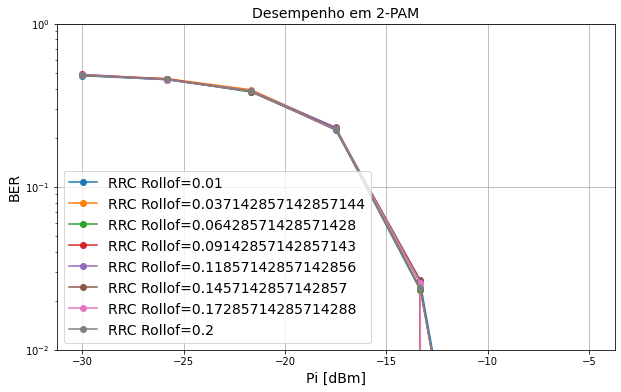

In [64]:
plt.figure(figsize=(10,6))
for i in range(len(rolloffArray)):
    plt.semilogy(Pi_dBmArray,BERArray[i], '-o',  label=f'RRC Rollof={rolloffArray[i]}')
plt.title('Desempenho em 2-PAM',fontsize=14)
plt.xlabel('Pi [dBm]',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.ylim(1e-2,1)
plt.legend(fontsize=14)
plt.grid()

### DC compensation

Progress: 40/40


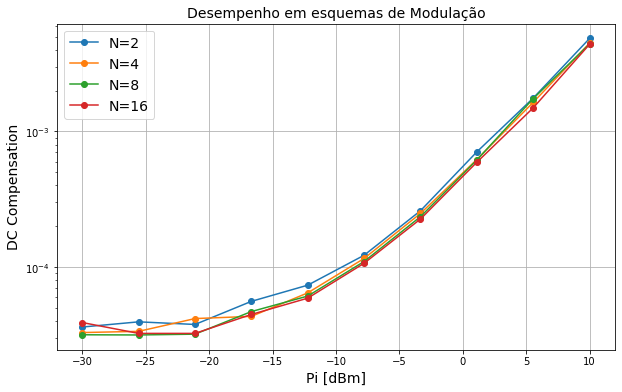

In [109]:
NArray = [2,4,8,16] # N-PAM Array
NumAm = 30000 # Número de símbolos
NumPts = 10 # Número de pontos
SpS = 32 # Samples per symbol

Rs  = 100e9  # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# pulso cosseno levantado (raised cosine)
Ncoeffs = 240
rolloff = 0.01
fftSize = 2**12 # FFT Size

Pi_dBmArray = np.linspace(-30,10,NumPts)      # Array da potência de sinal óptico na entrada do modulador em dBm

BERArray = np.zeros((len(NArray),NumPts))
DCArray = np.zeros((len(NArray),NumPts))

x = np.linspace(-Ta,Ta,Ncoeffs)
pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse1 = pulse1/np.max(np.abs(pulse1))
pulse1 = (np.multiply(pulse1,cos(x,Fa,0)))/np.max(np.abs(np.multiply(pulse1,cos(x,Fa,0))))
pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff, Ta)
#pulse2 = pulse2/np.max(np.abs(pulse2))
pulse2 = (np.multiply(pulse2,cos(x,2*Fa,0)))/np.max(np.abs(np.multiply(pulse2,cos(x,2*Fa,0))))

# parâmetros do receptor
Tc  = 25    # temperatura em Celsius
Rd  = 0.85  # responsividade em A/W
Id  = 5e-9  # corrente de escuro em nA
RL  = 50    # RL em Ohms
B   = 300e9   # banda do receptor em Hz
kB  = constants.value('Boltzmann constant')
q  = constants.value('elementary charge')

# detecta o sinal com o fotodiodo pin (modelo implementado no OptiCommPy)
paramPD = parameters()
paramPD.R = Rd         # responsividade em A/W
paramPD.Tc = Tc       # temperatura em Celsius
paramPD.Id = Id       # corrente de escuro em A
paramPD.RL = RL       # RL em Ohms
paramPD.B = B         # Largura de banda Hz
paramPD.Fs = Fa 
paramPD.ideal = False

for k in range(len(NArray)):
    for l in range(NumPts):

        N = NArray[k]

        Pi_dBm = Pi_dBmArray[l]   # potência de sinal óptico na entrada do modulador em dBm
        Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

        # Parâmetros MZM
        Vπ = 2
        Vb = -Vπ/2

        # ruído térmico
        T = Tc + 273.15     # temperatura em Kelvin

        ux = np.arange(-N+1,N,2)

        choiceArray = pnorm(ux)
        sTx1 = np.random.choice(choiceArray, NumAm) # Subchannel 1
        sTx2 = np.random.choice(choiceArray, NumAm) # Subchannel 2
        sTx = sTx1 + 1j*sTx2 # Complex representation of subchannels

        Vπ = Vπ*(choiceArray[int(N/2 - 1)]/ux[int(N/2 - 1)])*max(ux)
        Vb = max(ux)*(choiceArray[int(N/2 - 1)]/ux[int(N/2 - 1)])-Vπ

        # upsampling
        symbolsUp = upsample(sTx, SpS)

        # formatação de pulso 
        sigTx1 = firFilter(pulse1, symbolsUp.real)
        sigTx2 = firFilter(pulse2, symbolsUp.imag)

        # modulação óptica
        Ai = np.sqrt(Pi)*np.ones(np.size(sigTx1))
        sigTxo = mzm(Ai, sigTx1, Vπ, Vb)

        ### Receptor
        Pin = (np.abs(sigTxo)**2).mean()

        # ruído térmico
        σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

        I_RxNorm = photodiode(sigTxo, paramPD)
        I_Rx = I_RxNorm/np.std(I_RxNorm)

        ############ calculando a SNR na simulação

        # ruído de disparo 
        σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

        # fotocorrente livre de ruído
        Ip = Rd*np.abs(sigTxo)**2

        # ruído do receptor p-i-n aos sinais
        Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
        It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

        # filtragem Rx
        Nfilt = 8001
        h = lowPassFIR(B, Fa, Nfilt, typeF='rect')
        #h = pulseShape('nrz', SpS)

        Ip_Rx  = firFilter(h, Ip)
        Is_Rx  = firFilter(h, Is)
        It_Rx  = firFilter(h, It)

        # SNR estimada numericamente na simulação
        SNR_est = np.var(Ip_Rx)/(np.var(Is_Rx) + np.var(It_Rx))

        # captura amostras no meio dos intervalos de sinalização
        I_RxAm = I_Rx[0::SpS]

        # obtém estatísticas do sinal recebido
        IdArray = np.zeros(N-1)
        for i in range(N-1):
            IdArray[i] = np.average([choiceArray[i+1],choiceArray[i]]) + np.average(I_RxAm)
        #print(f'IdArray: {IdArray}')

        IdArray = np.pad(IdArray,(1,1),'constant', constant_values=(-10*N, 10*N))
        check = 0
        for i in range(IdArray.size - 1):
            for j in range(sTx1.size):
                if(ifBetween(I_RxAm[j], IdArray[i], IdArray[i+1]) and sTx1[j]==choiceArray[i]):
                    check = check + 1

        BER = (sTx1.size-check)/sTx1.size
        DCcomp = max(I_RxNorm) - np.std(I_RxNorm)*max(sTx1)

        Q  = np.arange(1, 11.1, 0.1)
        Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
        # print(f'Total de erros contados = {sTx1.size-check}')
        # print('BER = %.2e  '%(BER))

        BERArray[k,l] = BER
        DCArray[k,l] = DCcomp
        clear_output(wait=True)
        print(f'Progress: {(k*NumPts)+(l+1)}/{NumPts*len(NArray)}')

plt.figure(figsize=(10,6))
for i in range(len(NArray)):
    plt.semilogy(Pi_dBmArray,DCArray[i], '-o',  label=f'N={NArray[i]}')
plt.title('Desempenho em esquemas de Modulação',fontsize=14)
plt.xlabel('Pi [dBm]',fontsize=14)
plt.ylabel('DC Compensation',fontsize=14)
plt.legend(fontsize=14)
plt.grid()

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/BERxPi" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")